In [122]:
import sys
sys.path.insert(1, 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\impedance.py') #\\impedance')
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from impedance.circuits import CustomCircuit
from impedance.plotting import plot_nyquist
from impedance import preprocessing
from impedance import validation
from impedance.valid_BG import linKK

import ImpedanceCorrection as IC
import IC_plotting
%reload_ext autoreload
%autoreload 2

In [24]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*10%*.par')
all_files.sort()

f_name=all_files[-1]
print(f_name)
f0, Z0= preprocessing.readVersaStudio(f_name)

freqs, Z1 = preprocessing.ignoreBelowX(f0, Z0)

Z = Z1 - Z1.real[0]

C:\Users\shadd\OneDrive\Documents\Python\EIS
C:\Users\shadd\OneDrive\Documents\Python\EIS\Data\LSC_DPB1_FRXAS_700C_10%_EIS_OCV_afterFRXAS.par


In [25]:
M, mu, Z_linKK, res_real, res_imag = linKK(freqs, Z1, c=.8, max_M=100)

10 0.9994888642593683 4.660846484756838
20 0.9331215239742053 1.553542595904001


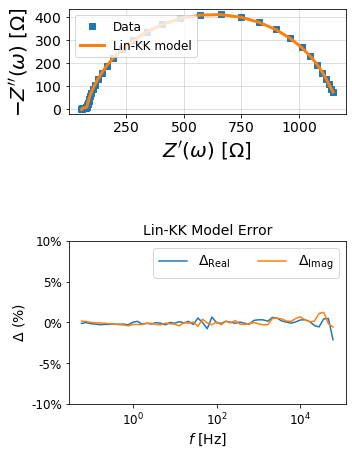

In [26]:
fig = plt.figure(figsize=(5,8))
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[:2,:])
ax2 = fig.add_subplot(gs[2,:])

# plot original data
plot_nyquist(ax1, freqs, Z1, fmt='s')

# plot measurement model
plot_nyquist(ax1, freqs, Z_linKK, fmt='-', scale=1e3, units='\Omega')

ax1.legend(['Data', 'Lin-KK model'], loc=2, fontsize=12)

# Plot residuals
ax2.plot(freqs, res_real, '-', label=r'$\Delta_{\mathrm{Real}}$')
ax2.plot(freqs, res_imag, '-', label=r'$\Delta_{\mathrm{Imag}}$')
ax2.set_title('Lin-KK Model Error', fontsize=14)

ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_ylabel('$\Delta$ $(\%)$', fontsize=14)
ax2.set_xlabel('$f$ [Hz]', fontsize=14)
ax2.set_xscale('log')
ax2.set_ylim(-.1, .1)

ax2.legend(loc=1, fontsize=14, ncol=2)

vals = ax2.get_yticks()
ax2.set_yticklabels(['{:.0%}'.format(x) for x in vals])

plt.tight_layout()
plt.show()

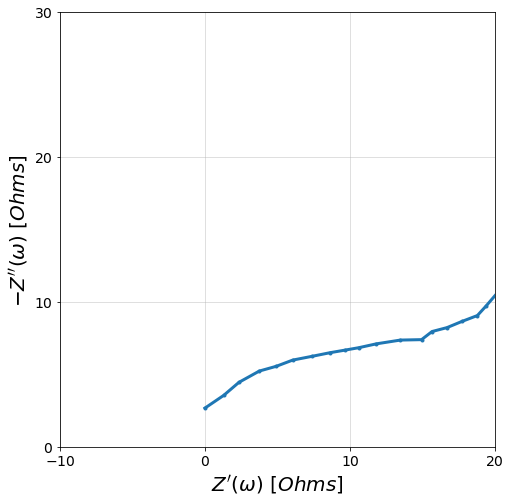

In [383]:
f_adj, Z_adj = freqs[1:], Z1[1:]

Z_adj = Z_adj - Z_adj.real[0]

fig, ax = plt.subplots(figsize=(8,8))

plot_nyquist(ax, f_adj, Z_adj)

ax.set_xlim(-10, 20)
ax.set_ylim(0,30)
plt.show()

### Subtracting a Gerischer admittance from this using tg=0.7 as fit from fr-XAS
### Varying the Rg to see what might be appropriate

40 (723.1285381139985-561.9709048906191j) 15.974953085220818 0 0
40 (709.9682955826443-552.8779633434982j) 13.18225869296748 0 0
40 (697.8379072167482-544.462240319276j) 10.684670908281987 0 0
40 (686.6325558211782-536.6588923317887j) 8.443061849519609 0 0
40 (676.2609759723205-529.410936248449j) 6.424524170381574 0 0
40 (666.6433321152924-522.6680953626503j) 4.601227484149945 0 0
40 (657.7094831642361-516.3858425272557j) 2.949511809315311 0 0
40 (649.39755395574-510.5246022948301j) 1.4491636633289318 0 0
40 (641.6527521133094-505.0490821552175j) 0.08283404314352083 0 0
40 (634.4263825394416-499.92770920273887j) -1.1644325342996353 0 0
40 (627.6750220892812-495.132153383513j) -2.3055814388058593 0 0


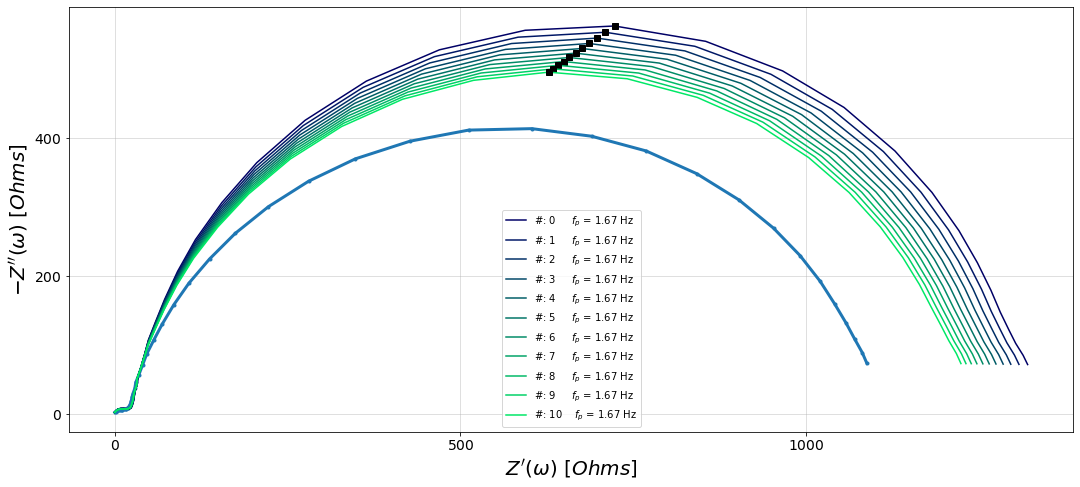

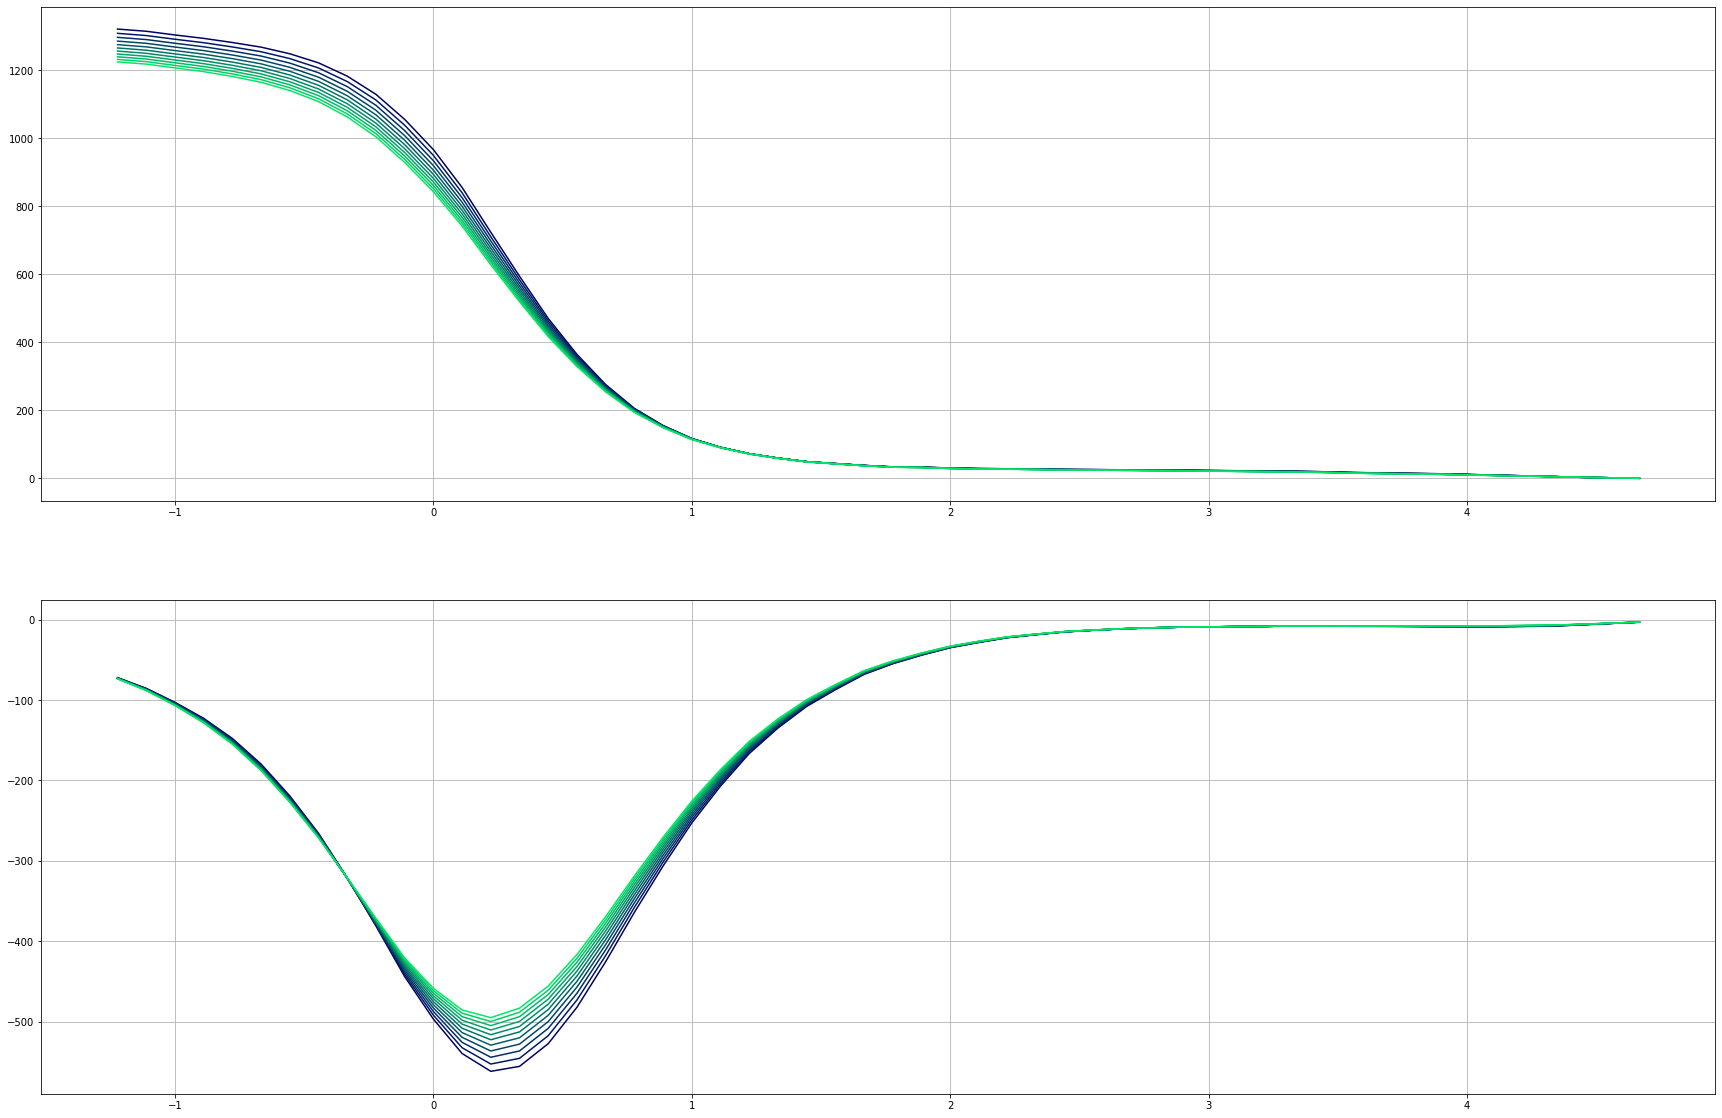

In [384]:
# par_out, ax0, ax1, ax2 = IC.sub_Zg_parallel(f_adj, Z_adj, .7, [3.3, 3.8], num=13)
par_out = IC.sub_Zg_parallel(f_adj, Z_adj, .7, [3.8, 4], num=11, show_plot=False)
# ax0.set_xlim((-2, 20))
# ax0.set_ylim((-2, 20))
fig, ax = plt.subplots(figsize=(18, 12))
fig2, (ax1, ax2) = plt.subplots(nrows=2, figsize=(30, 20))
plot_nyquist(ax, freqs, Z_adj)

for i, Zs in enumerate(par_out):
#     print(sum(n < 0 for n in np.diff(Zs)), sum(n < -1 for n in Zs.real))
    min_ind = np.argmin(Zs.imag)
    print(min_ind, Zs[min_ind], Zs[min_ind+1].imag - Zs[min_ind-1].imag, sum(n < 0 for n in np.diff(Zs)), sum(n < -1 for n in Zs.real))
    if sum(n < 0 for n in np.diff(Zs)) == 0 and sum(n < -1 for n in Zs.real) < 2:
        f_p_idx = np.argmin(np.imag(Zs))
        f_p = f_adj[f_p_idx]

        ax.plot(Zs.real, -Zs.imag, label='#: %d \t $f_p$ = %.2f Hz' % (i, f_p),
                c=(0, i/len(par_out), .4))
        ax.plot(Zs[f_p_idx].real, -Zs[f_p_idx].imag, 's',
                c=(0, 0, 0))
        ax1.plot(np.log10(f_adj), Zs.real, label='%.2f Hz' % f_p,
                c=(0, i/len(par_out), .4))
        ax2.plot(np.log10(f_adj), Zs.imag, label='%.2f Hz' % f_p,
                c=(0, i/len(par_out), .4))

        # ax.set_xlim(-80, 300)
        # ax.set_ylim(-80, 300)
        ax1.grid(True)
        ax2.grid(True)
        ax.legend()
        

In [302]:
def Res_fun(Rg, f, Z, tg):
    from impedance.circuit_elements import G
    Y = 1 / Z
    p = [Rg[0], tg]
    Zg = G(p, f)
    Yg = 1 / Zg
    Y_adj = Y - Yg
    Z_adj = 1 / Y_adj
    
    min_ind = np.argmin(Z_adj.imag)
    
    
    res = Z_adj[min_ind+1].imag - Z_adj[min_ind-1].imag
    print(min_ind, Rg, res, np.min(Z_adj.imag))
#     print(min_ind, Z_adj[min_ind], Z_adj[min_ind+1].imag - Z_adj[min_ind-1].imag
    return res

In [385]:
result = least_squares(Res_fun, 10**3.9, args=(f_adj, Z_adj, .7), bounds=([1e3], [1e4]))
result

40 [7943.28234724] 4.601227484149945 -522.6680953626503
40 [7943.28246561] 4.601226923113359 -522.6680932576155
40 [8602.7588506] 1.8376036527670294 -512.0568370883572
40 [8602.75897879] 1.8376031780430253 -512.0568352221834
40 [8968.93073322] 0.5642621669717869 -506.9939851110396
40 [8968.93086687] 0.5642617306088482 -506.99398335600114
40 [9116.94213765] 0.09267333657948029 -505.0890053775799
40 [9116.9422735] 0.09267291419138246 -505.089003663884
40 [9145.77550067] 0.0034463613030766282 -504.72669633638424
40 [9145.77563696] 0.00344594154466904 -504.726694630522
40 [9146.8929647] 5.1326247216820775e-06 -504.71271103424334
40 [9146.893101] 4.7129674953794165e-06 -504.7127093286832
40 [9146.89463171] 1.1198153515579179e-11 -504.7126901744082
40 [9146.89476801] -4.196460281491454e-07 -504.71268846884874


 active_mask: array([0])
        cost: 6.269932107923916e-23
         fun: array([1.11981535e-11])
        grad: array([-3.44784182e-14])
         jac: array([[-0.00307894]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 7
        njev: 7
  optimality: 2.941372364027699e-11
      status: 1
     success: True
           x: array([9146.89463171])


Circuit string: R0-p(R1,E1)
Fit: True

Initial guesses:
     R0 = 2.10e+01 [Ohm]
     R1 = 1.24e+03 [Ohm]
   E1_0 = 7.70e-05 [Ohm^-1 sec^a]
   E1_1 = 8.00e-01 []

Fit parameters:
     R0 = 1.92e+01  (+/- 6.85e-01) [Ohm]
     R1 = 1.24e+03  (+/- 1.44e+00) [Ohm]
   E1_0 = 1.04e-04  (+/- 3.50e-07) [Ohm^-1 sec^a]
   E1_1 = 8.68e-01  (+/- 1.27e-03) []



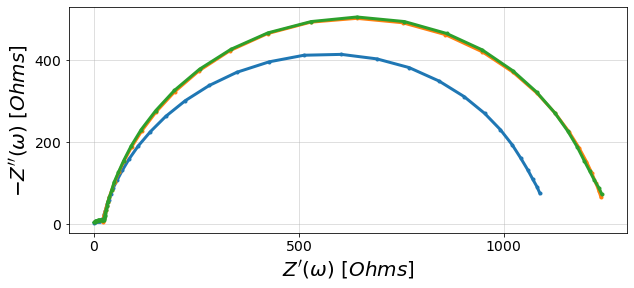

In [388]:
par_out= IC.sub_Zg_parallel(f_adj, Z_adj, .7, result.x, num=11, show_plot=False)

f_p = f_adj[np.argmin(par_out.imag)]
C_guess = 1 / (2*np.pi * f_p * par_out[0, -1].real)
PostZg = CustomCircuit(circuit='R0-p(R1,E1)', initial_guess=[par_out[0,15].real, par_out[0,-1].real, C_guess, .8])
PostZg.fit(f_adj[15:], par_out[0, 15:])
print(PostZg)
Z_pZg = PostZg.predict(f_adj[15:]) 

fig, ax = plt.subplots(figsize=(10,10))
plot_nyquist(ax, f_adj, Z_adj)
plot_nyquist(ax, f_adj, Z_pZg)
plot_nyquist(ax, f_adj, par_out[0])

array([102.68292084, 101.38288754, 100.98913241, 100.61230393,
       100.19894394,  99.8404122 ,  99.38046551,  98.88253584,
        98.25880699,  97.5144875 ,  96.70582771,  95.84382733,
        94.65864118,  93.25085285,  91.45133211,  89.31505819,
        86.66688381,  83.20112787,  79.25302775,  74.60692743,
        68.71190921,  62.99890249,  55.70645151,  48.52839937,
        40.61780355,  35.2013561 ,  24.35088408,  17.09852914,
        13.48189727,   3.13574306,  -2.28392597, -10.47956975,
       -15.93020999, -22.3921026 , -25.95907645, -30.11722155,
       -32.17575386, -34.22281991, -36.31035192, -37.08478658,
       -38.22968898, -37.54043285, -37.30939321, -37.24082677,
       -35.11655294, -32.74448534, -29.56207408, -26.30912297,
       -22.67714586, -19.33817584, -16.61196453, -14.39959947,
       -12.22259444, -10.65596778])

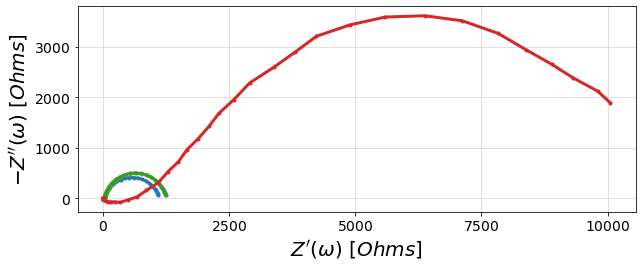

In [391]:
ZZ = IC.par_RCPE_subtract(PostZg.parameters_[1:], f_adj, Z_adj)

fig, ax = plt.subplots(figsize=(10,10))
plot_nyquist(ax, f_adj, Z_adj)
plot_nyquist(ax, f_adj, Z_pZg)
plot_nyquist(ax, f_adj, par_out[0])
plot_nyquist(ax, f_adj, ZZ)
np.angle(ZZ, deg=True)
# ax.set_xlim(-10,300)
# ax.set_ylim(-80,30)

In [144]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*1%*.par')
all_files.sort()

f_name=all_files[-1]
print(f_name)
f0, Z0 = preprocessing.readVersaStudio(f_name)

freqs, Z1 = preprocessing.ignoreBelowX(f0, Z0)

Z = Z1 - Z1.real[0]

C:\Users\shadd\OneDrive\Documents\Python\EIS
C:\Users\shadd\OneDrive\Documents\Python\EIS\Data\LSC_DPB1_FRXAS_700C_100%_EIS_OCV_before2.par


24 (686.898087322533-562.8687843225954j) 12.825167569241444 0 0
24 (674.9713187380408-553.6919165768278j) 10.323176303795321 0 0
24 (663.9611183159086-545.2024563688464j) 8.081499163629246 0 0
24 (653.7761633035259-537.3340279601216j) 6.066164418275321 0 0
24 (644.3366909504435-530.0283880749315j) 4.248518621541052 0 0
24 (635.5727239749295-523.2342167977613j) 2.6042632756787043 0 0
24 (627.4226133300834-516.9061180157194j) 1.1126883454375616 0 0
24 (619.8318340094988-511.0037882517951j) -0.2439419269109635 0 0
24 (612.7519840830935-505.49132171376755j) -1.4808844457147075 0 0
24 (606.1399480493834-500.3366262185423j) -2.611319394146733 0 0
24 (599.9571938768203-495.51092989642814j) -3.6466785708575458 0 0


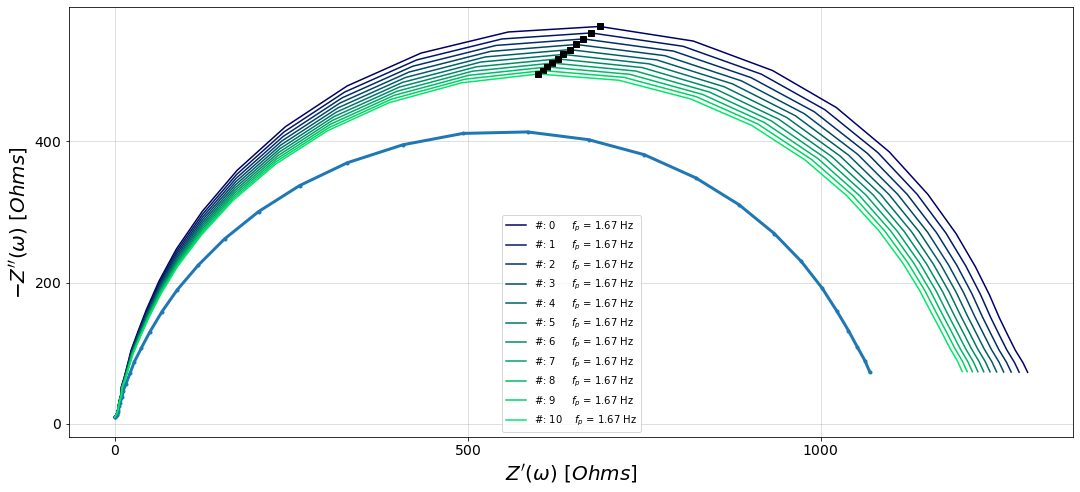

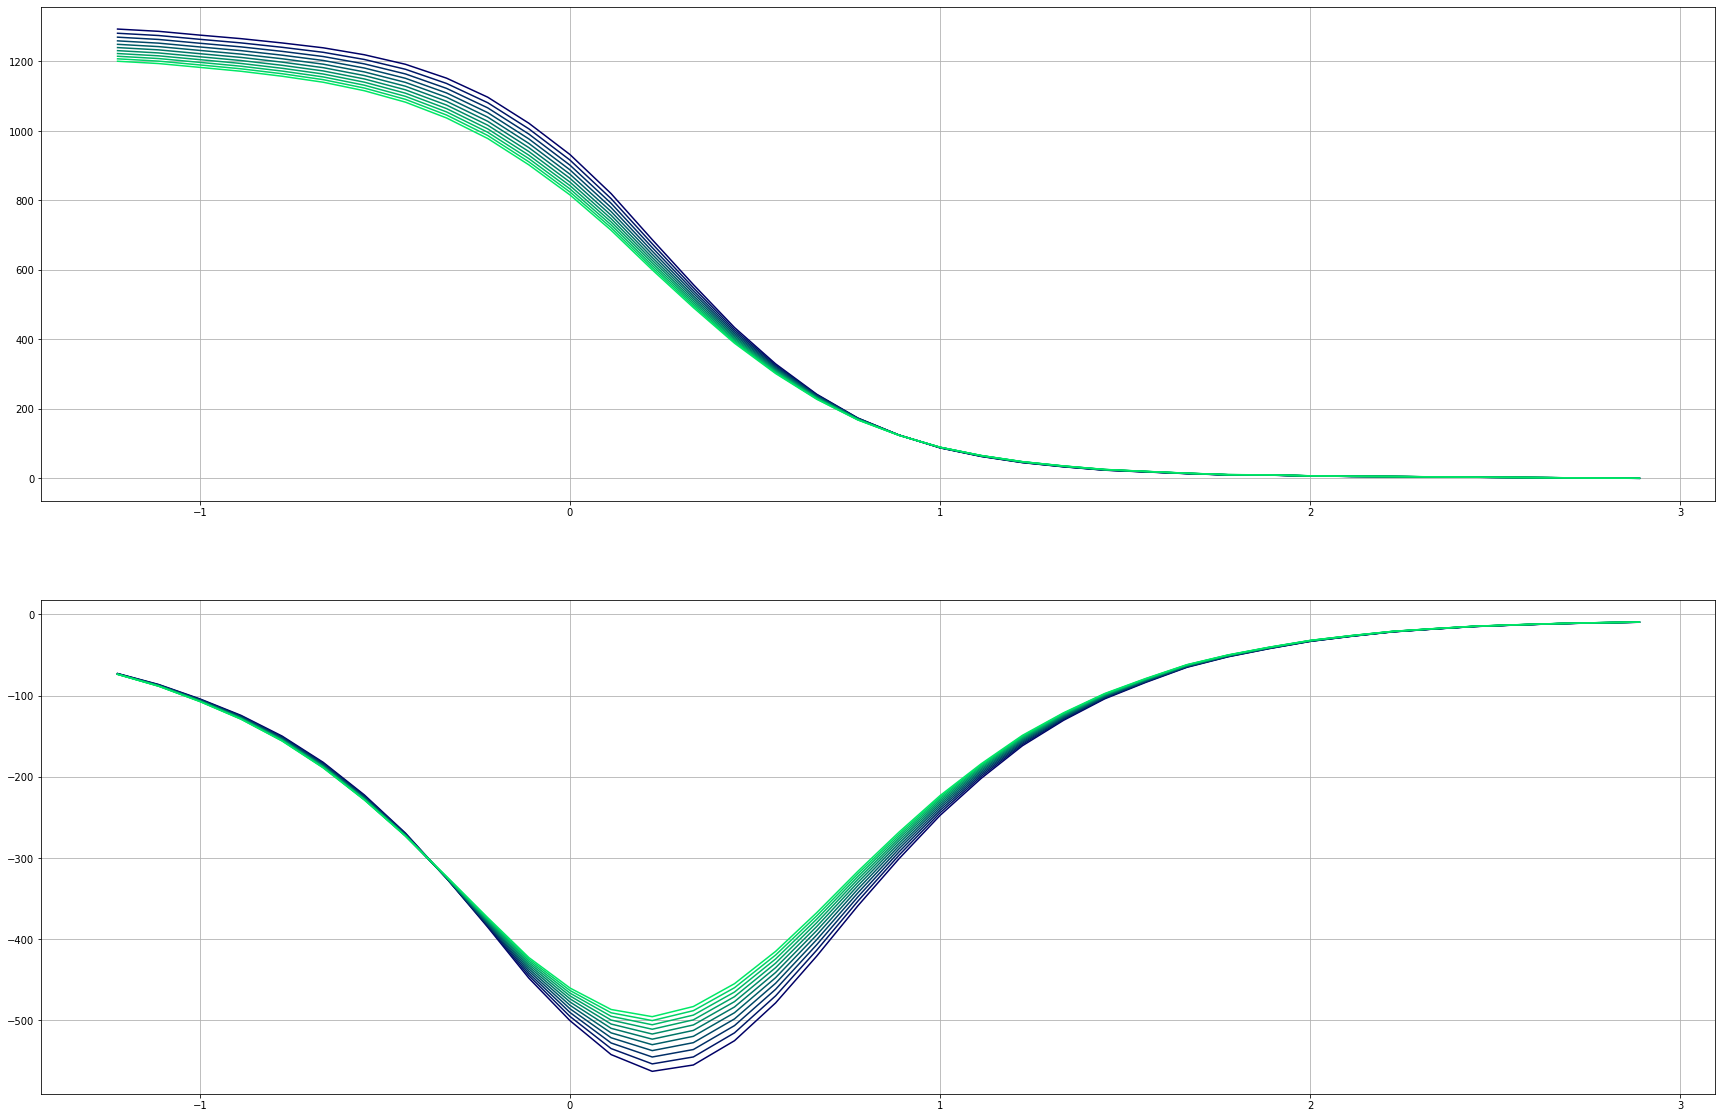

In [331]:
# par_out, ax0, ax1, ax2 = IC.sub_Zg_parallel(f_adj, Z_adj, .7, [3.3, 3.8], num=13)
par_out = IC.sub_Zg_parallel(f_adj, Z_adj, .91, [3.8, 4], num=11, show_plot=False)
# ax0.set_xlim((-2, 20))
# ax0.set_ylim((-2, 20))
fig, ax = plt.subplots(figsize=(18, 12))
fig2, (ax1, ax2) = plt.subplots(nrows=2, figsize=(30, 20))
plot_nyquist(ax, freqs, Z_adj)

for i, Zs in enumerate(par_out):
#     print(sum(n < 0 for n in np.diff(Zs)), sum(n < -1 for n in Zs.real))
    min_ind = np.argmin(Zs.imag)
    print(min_ind, Zs[min_ind], Zs[min_ind+1].imag - Zs[min_ind-1].imag, sum(n < 0 for n in np.diff(Zs)), sum(n < -1 for n in Zs.real))
    if sum(n < 0 for n in np.diff(Zs)) == 0 and sum(n < -1 for n in Zs.real) < 2:
        f_p_idx = np.argmin(np.imag(Zs))
        f_p = f_adj[f_p_idx]

        ax.plot(Zs.real, -Zs.imag, label='#: %d \t $f_p$ = %.2f Hz' % (i, f_p),
                c=(0, i/len(par_out), .4))
        ax.plot(Zs[f_p_idx].real, -Zs[f_p_idx].imag, 's',
                c=(0, 0, 0))
        ax1.plot(np.log10(f_adj), Zs.real, label='%.2f Hz' % f_p,
                c=(0, i/len(par_out), .4))
        ax2.plot(np.log10(f_adj), Zs.imag, label='%.2f Hz' % f_p,
                c=(0, i/len(par_out), .4))

        # ax.set_xlim(-80, 300)
        # ax.set_ylim(-80, 300)
        ax1.grid(True)
        ax2.grid(True)
        ax.legend()
        

C:\Users\shadd\OneDrive\Documents\Python\EIS


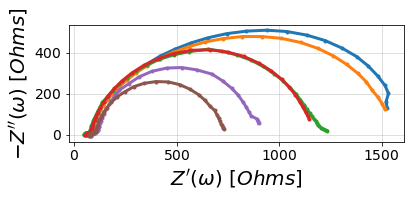

In [15]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*.par')
all_files.sort()

fig, ax = plt.subplots()

for file in all_files:
    f, Z = preprocessing.readVersaStudio(file)
    plot_nyquist(ax, f, Z)

    
# ax.set_xlim(40,150)
# ax.set_ylim(0,100)
plt.show()

In [173]:
all_files

['C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before2.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_10%_EIS_OCV_after.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_10%_EIS_OCV_afterFRXAS.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_100%_EIS_OCV_after.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_100%_EIS_OCV_before2.par']

In [143]:
from impedance.validation import linKK

In [ ]:
linKK()